In [1]:
import pandas as pd
import numpy as np
import pyranges as pr
import os
import sys
from collections import Counter
import gget
import scipy
import scanpy as sc
from kneed import KneeLocator
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("../")
import utils as ut

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.processed.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

In [3]:
def get_hard_threshold(adata, plot=True):
    """A function to get the optimal hard threshold of a data matrix.
    Used to guide the choice of principal components """

    # OHT METHOD
    eigs = adata.uns['pca']['variance']
    tau = 2.858 * np.median(eigs)
    index = np.argwhere(eigs >= tau)
    oht = np.max(index) 

    # KNEED METHOD
    kneedle = KneeLocator(list(range(len(eigs))), 
                          eigs, 
                          S=1.0, 
                          curve="convex", 
                          direction="decreasing")
    knee = kneedle.knee
    print(f"{oht=} {knee=}")

    if plot:
        plt.plot(eigs, 
                 marker=".", 
                 c='k')
        plt.yscale('log')
        plt.ylabel(r"Magnitude")
        plt.xlabel("Eigenvalue")
        plt.title("Eigenvalues of Covariance Matrix")
        plt.axvline(x=oht, c='r', label=f'OHT ({oht})')
        plt.axvline(x=knee, c='b', label=f'Knee ({knee})')
        plt.legend()
        sns.despine()

highly_variable
False    12436
True      2500
Name: count, dtype: int64

n_pca=2499 explained_variance=1.0000
oht=602 knee=19


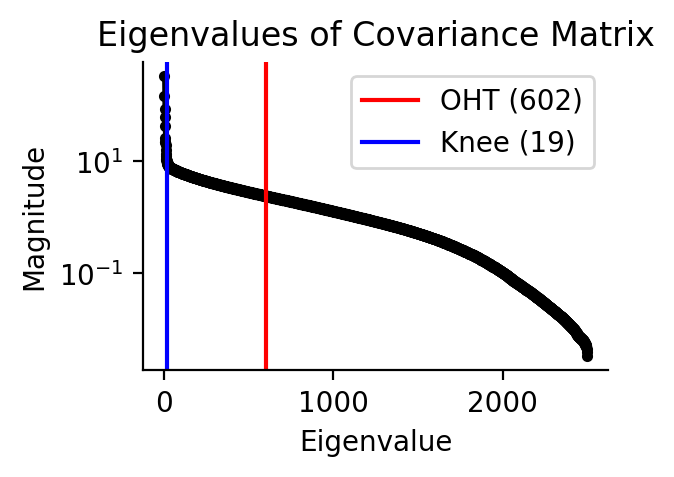

In [4]:
n_genes = 2500
n_pca = n_genes - 1  # full rank decomposition

sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)

print(adata.var['highly_variable'].value_counts())
print()

# recompute the PCA using highly variable genes
sc.tl.pca(adata, 
          n_comps=n_pca, 
          use_highly_variable=True)

# print the total explained variance
explained_variance = adata.uns['pca']['variance_ratio'].sum()

print(f"{n_pca=} {explained_variance=:0.4f}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
get_hard_threshold(adata)

# TSNE for vizualization

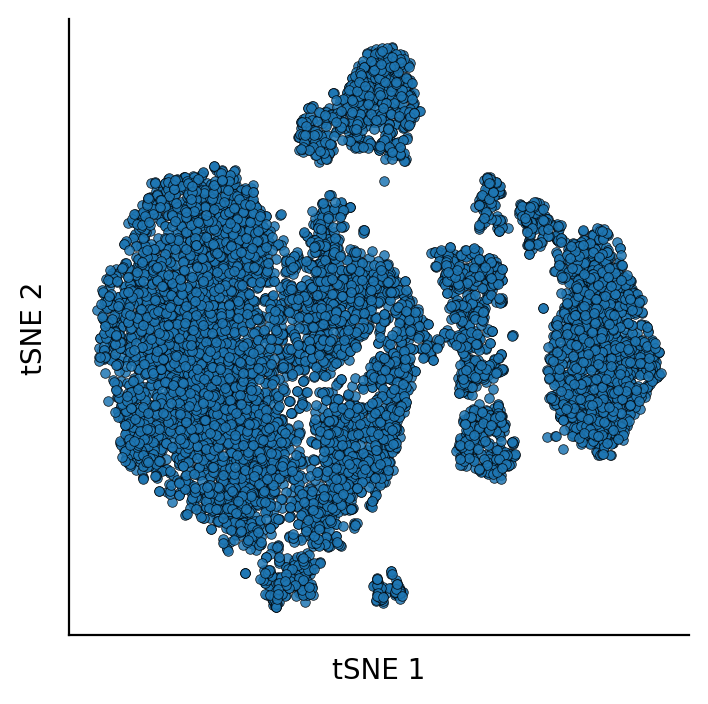

In [5]:
sc.tl.tsne(adata, 
           n_pcs=20, 
           use_fast_tsne=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.scatterplot(data=adata.obs,
                x=adata.obsm['X_tsne'][:, 0],
                y=adata.obsm['X_tsne'][:, 1],
                s=12,
                alpha=0.85,
                ec='k')

_ = plt.yticks([])
_ = plt.xticks([])
plt.ylabel("tSNE 2")
plt.xlabel("tSNE 1")
sns.despine()

# The resolution parameter

2024-01-26 10:44:24.199451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 10:44:24.382712: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 10:44:25.336416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-26 10:44:25.336509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

Resolution r=0.010
Resolution r=0.042
Resolution r=0.074
Resolution r=0.107
Resolution r=0.139
Resolution r=0.171
Resolution r=0.203
Resolution r=0.236
Resolution r=0.268
Resolution r=0.300


,resolution,n_clusters,score
0,0.010000,1,0.000000
1,0.042222,2,0.101489
2,0.074444,3,0.073529
3,0.106667,5,0.074013
4,0.138889,4,0.075516


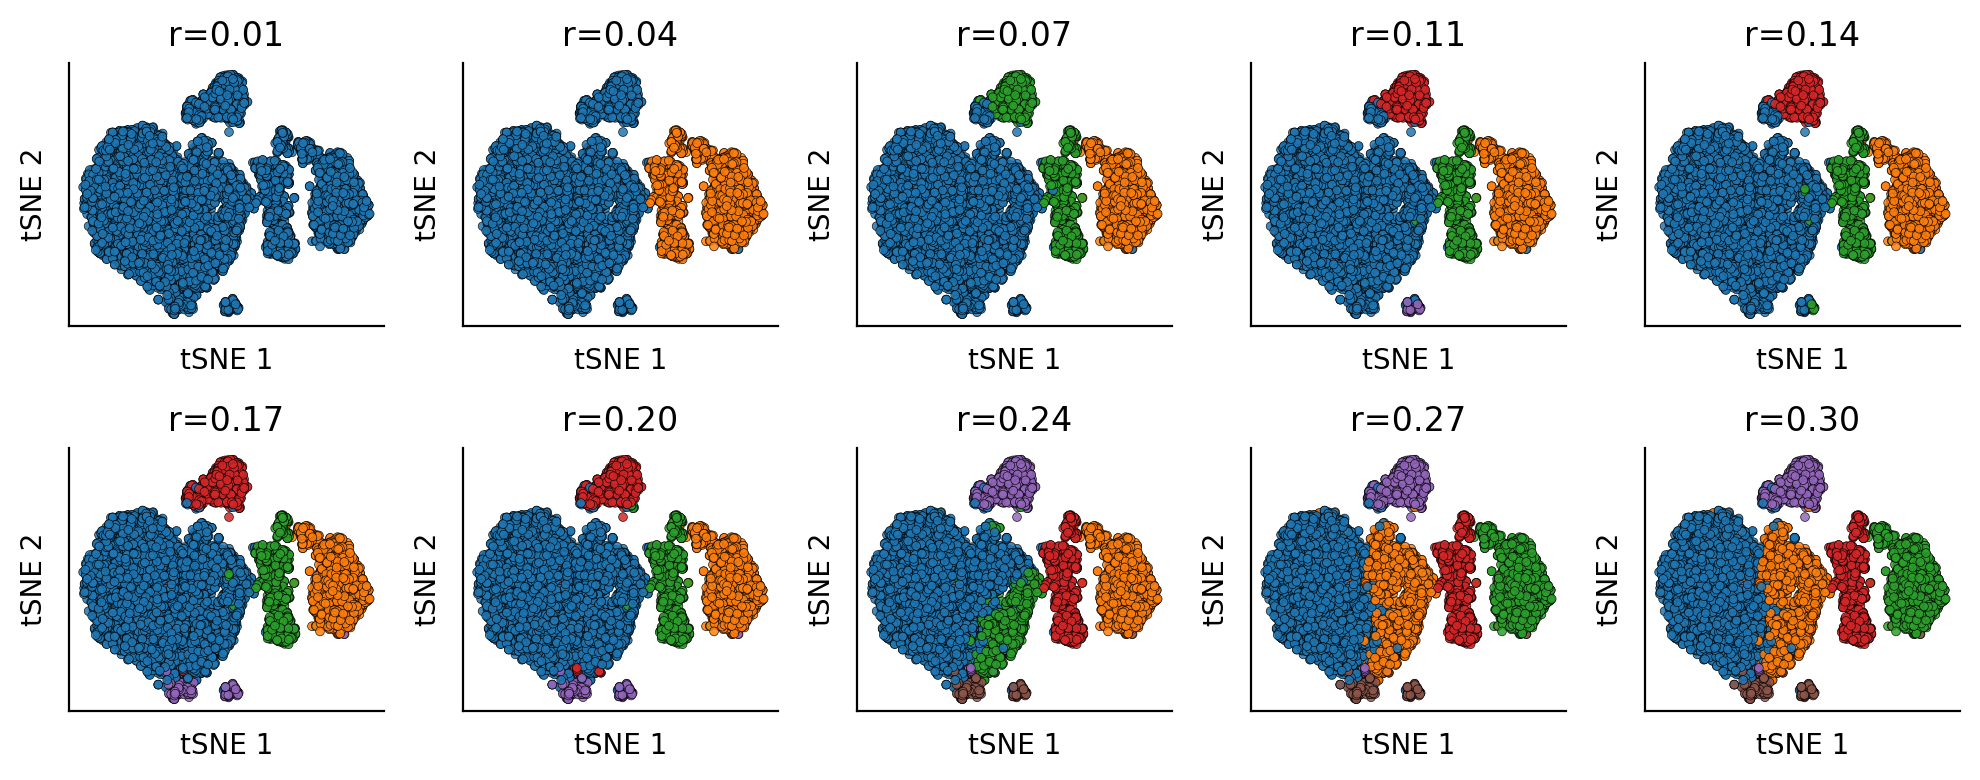

In [6]:
n_pca = 25 # from above
n_neighbors = 15
resolutions = np.linspace(0.01, 0.30, 10)

# establish the nieghborhood
sc.pp.neighbors(adata, 
                n_neighbors=n_neighbors, 
                n_pcs=n_pca,)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4
fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

res = []
for i, r in enumerate(resolutions):
    print(f"Resolution {r=:.3f}")

    # perform clustering
    sc.tl.leiden(adata, resolution=r)

    sns.scatterplot(data=adata.obs,
                    x=adata.obsm['X_tsne'][:, 0],
                    y=adata.obsm['X_tsne'][:, 1],
                    s=10,
                    hue='leiden',
                    ax=axs[i],
                    legend=False,
                    alpha=0.85,
                    ec='k')

    axs[i].set_title(f"{r=:.2f}")
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("tSNE 2")
    axs[i].set_xlabel("tSNE 1")

    # compute the sillhoute score
    X = adata.X[:, adata.var['highly_variable']]
    labels = adata.obs['leiden'].values
    if len(set(labels)) == 1:
        score = 0
    else:
        score = sklearn.metrics.silhouette_score(X, labels)

    row = {
        'resolution' : r,
        'n_clusters' : len(set(labels)),
        'score' : score,
    }
    res.append(row)

plt.tight_layout()
sns.despine()

res = pd.DataFrame(res)
res.head()

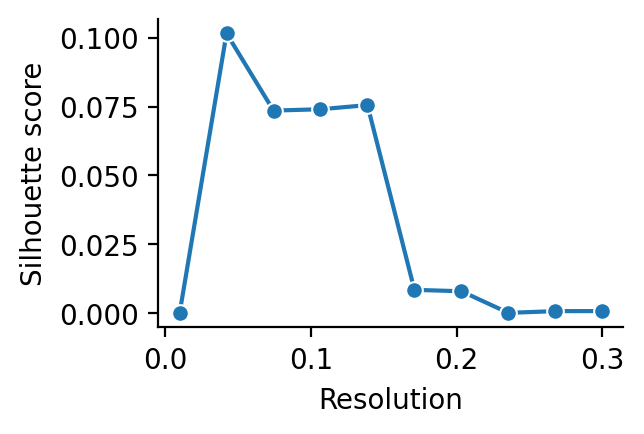

In [7]:
# plot the scores by resolution

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
sns.lineplot(data=res.copy(),
             x='resolution',
             y='score',
             marker="o")

plt.ylabel("Silhouette score")
plt.xlabel("Resolution")
sns.despine()

# Number of neighbors

N neighbors int(n)=5
N neighbors int(n)=15
N neighbors int(n)=26
N neighbors int(n)=36
N neighbors int(n)=47
N neighbors int(n)=57
N neighbors int(n)=68
N neighbors int(n)=78
N neighbors int(n)=89
N neighbors int(n)=100


,n_neighbors,n_clusters,score
0,5,5,0.007600
1,15,4,0.075720
2,26,3,0.073122
3,36,3,0.076207
4,47,3,0.073178


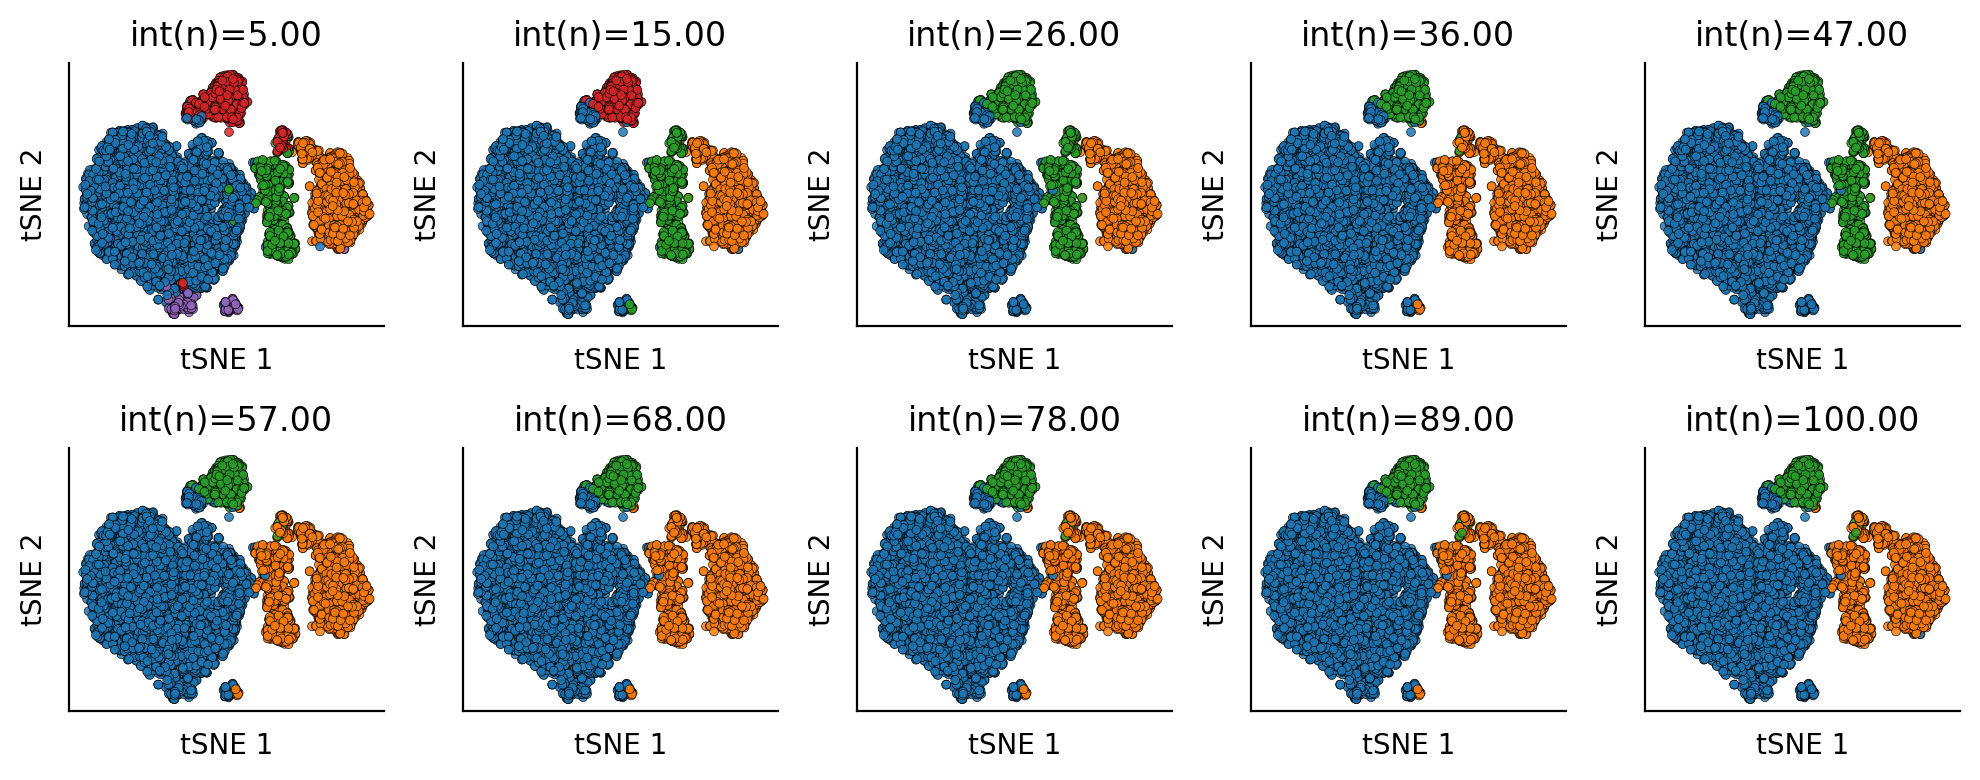

In [8]:
n_pca = 25 # from above
resolution = 0.1
n_neighbors = np.linspace(5, 100, 10)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4
fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

res = []
for i, n in enumerate(n_neighbors):
    print(f"N neighbors {int(n)=}")
    # establish the nieghborhood
    sc.pp.neighbors(adata, 
                    n_neighbors=int(n), 
                    n_pcs=n_pca,)

    # perform clustering
    sc.tl.leiden(adata, resolution=resolution)

    sns.scatterplot(data=adata.obs,
                    x=adata.obsm['X_tsne'][:, 0],
                    y=adata.obsm['X_tsne'][:, 1],
                    s=10,
                    hue='leiden',
                    ax=axs[i],
                    legend=False,
                    alpha=0.85,
                    ec='k')

    axs[i].set_title(f"{int(n)=:.2f}")
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("tSNE 2")
    axs[i].set_xlabel("tSNE 1")

    # compute the sillhoute score
    X = adata.X[:, adata.var['highly_variable']]
    labels = adata.obs['leiden'].values
    if len(set(labels)) == 1:
        score = 0
    else:
        score = sklearn.metrics.silhouette_score(X, labels)

    row = {
        'n_neighbors' : int(n),
        'n_clusters' : len(set(labels)),
        'score' : score,
    }
    res.append(row)

plt.tight_layout()
sns.despine()

res = pd.DataFrame(res)
res.head()

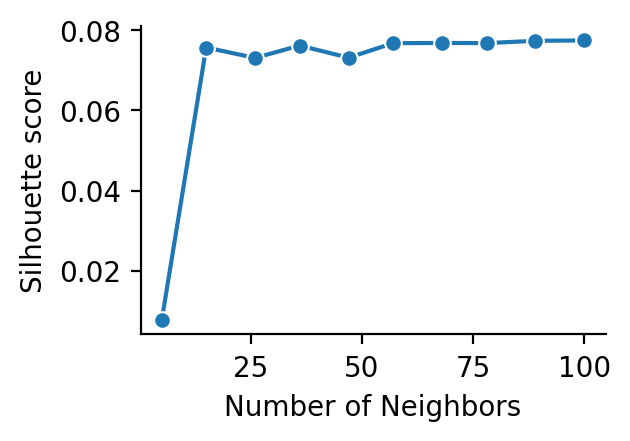

In [9]:
# plot the scores by resolution

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
sns.lineplot(data=res.copy(),
             x='n_neighbors',
             y='score',
             marker="o")

plt.ylabel("Silhouette score")
plt.xlabel("Number of Neighbors")
sns.despine()

# clustering 

In [10]:
n_pca = 25 # from above 
n_neighbors = 15
resolution = 0.1
key = f"clusters"

explained_variance = adata.uns['pca']['variance_ratio'].cumsum()[n_pca-1]
print(f"{n_pca=} {explained_variance=:.4f}")

# establish the nieghborhood
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pca,)

# perform clustering
sc.tl.leiden(adata, 
             resolution=resolution,
             key_added=key)

adata.obs['cluster_name'] = adata.obs['clusters'].astype(int).apply(lambda x: f"C{x+1}")
adata.obs['cluster_name'].value_counts()

n_pca=25 explained_variance=0.1964


cluster_name
C1    5565
C2    1449
C3     911
C4     559
Name: count, dtype: int64

... storing 'cluster_name' as categorical


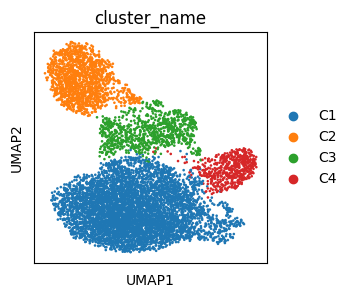

In [11]:
min_distance = 0.8
spread = 1
color_map = "nipy_spectral"

# build coarse-grained connectivity structures of complex manifolds 
sc.tl.paga(adata, groups='clusters')
sc.pl.paga(adata, plot=False)

# new embedding from the corse grained structures
sc.tl.umap(adata, 
           init_pos='paga',
           min_dist=min_distance, 
           spread=spread)

# build new obs columns
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color=['cluster_name'])

# UMAP Plot

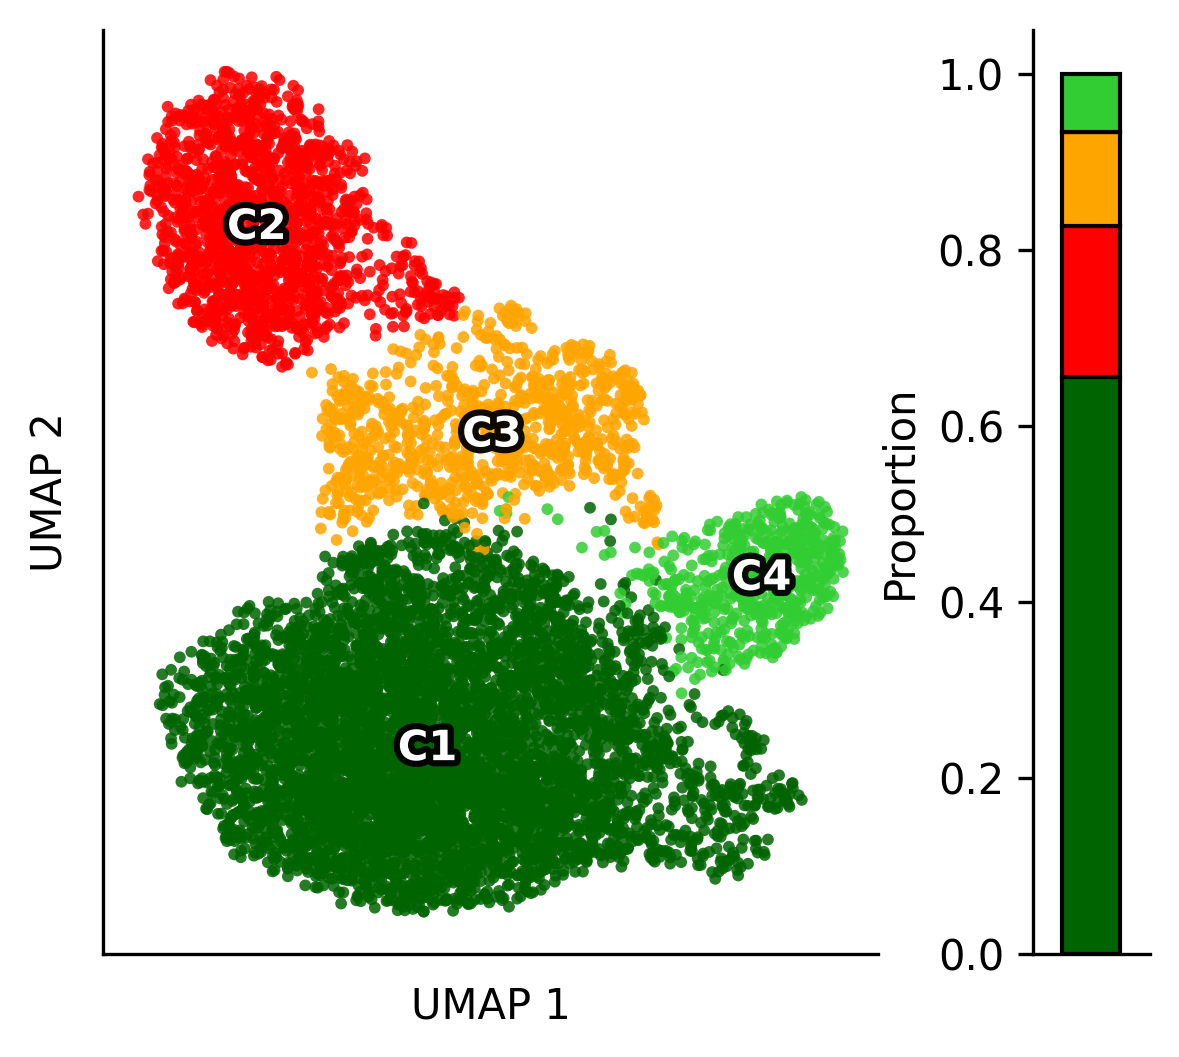

In [12]:
""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 4

colors = ['darkgreen', 'red', "orange", "limegreen"]


sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=colors,
                s=8,
                alpha=0.85,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

def label_pos(labels, ax, color='w', fontsize=10,
              fw='bold', highlight="k", highlight_weight=3):
    """A function to add labels to each cluster """
    for idx, label_record in labels.iterrows():
        ax.text(
            label_record['UMAP 1'],
            label_record['UMAP 2'],
            label_record['label'],
            path_effects=[pe.withStroke(linewidth=highlight_weight, 
                                        foreground=highlight, 
                                        alpha=0.95,)],
            weight=fw,
            color=color,
            verticalalignment="center",
            horizontalalignment="center",
            fontsize=fontsize,
        )

all_pos = adata.obs.groupby('cluster_name')[['UMAP 1', 'UMAP 2']].median().reset_index()
all_pos.columns = ['label', 'UMAP 1', 'UMAP 2']

label_pos(all_pos, ax)

plt.gca().legend().remove()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%")

t = adata.obs['clusters'].value_counts(normalize=True).reset_index(drop=False).T
new_header = t.iloc[0] 
t = t[1:]
t.columns = ['C1', 'C2', 'C3', 'C4']
t.plot(kind='bar', 
       stacked=True,
       legend=False,
       color=colors,
       ax=cax,
       ec='k')

cax.set_xlabel("")
cax.set_xticks([])
cax.set_ylabel("Proportion")

sns.despine()

# Store the data

In [13]:
outpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"
adata.write(outpath)
adata

AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'tsne', 'neighbors', 'leiden', 'paga', 'clusters_sizes', 'umap', 'cluster_name_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'